In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=10000) # just read first 100000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(147331, 4)

In [8]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [9]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [-1.43123397e-01,  7.72218759e-01, -5.37015154e+00,
         5.42727682e+00],
       [-2.31257017e-01, -6.81425110e-01,  1.42509806e+00,
         1.59647251e+00],
       [ 2.34250895e-01,  3.07633892e-01,  2.66273882e+01,
         2.66301955e+01]])

In [10]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [11]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 4
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
z_mean = Dense(latent_dim)(h3)
z_log_sigma = Dense(latent_dim)(h2)

In [16]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [17]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(z)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [18]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [19]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [20]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8)            136         dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
batch_size = 1000
epochs = 100

In [23]:
x_train.shape

(117864, 4)

In [24]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [25]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 117864 samples, validate on 14733 samples
Epoch 1/100
117864/117864 [==============================] - 1s 10us/step - loss: 1.0110 - val_loss: 0.9693
Epoch 2/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.9138 - val_loss: 0.8750
Epoch 3/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.7231 - val_loss: 0.6466
Epoch 4/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.6369 - val_loss: 0.6129
Epoch 5/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.5782 - val_loss: 0.5399
Epoch 6/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.5183 - val_loss: 0.4986
Epoch 7/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.4841 - val_loss: 0.4721
Epoch 8/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.4639 - val_loss: 0.4576
Epoch 9/100
117864/117864 [==============================] - 1s 5us/step - loss: 0.4474 - va

# Visualization

In [26]:
import matplotlib.pyplot as plt

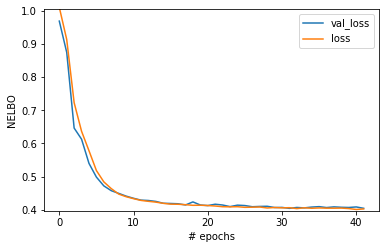

In [27]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [31]:
predictions = vae.predict(x_test)

In [32]:
predictions

array([[-1.37734637e-01,  1.26551539e-02,  8.13309327e-02,
        -2.64836758e-01],
       [-3.01691145e-02, -5.31171262e-03, -2.86649093e-02,
        -4.16369706e-01],
       [ 2.38518906e+00,  2.15741825e+00,  1.19080074e-01,
         1.60433149e+00],
       ...,
       [ 6.96893036e-03, -9.89799201e-03, -2.50443071e-03,
        -3.88776034e-01],
       [ 1.20343268e-03, -1.54505223e-02, -4.33181971e-03,
        -3.99052709e-01],
       [ 5.59486449e-03, -4.39211726e-04, -1.26902685e-02,
        -3.87264699e-01]], dtype=float32)

In [33]:
distr = (x_test - predictions) / (x_test)

In [34]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [35]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [49]:
all_pred = K.flatten(predictions)
all_test = K.flatten(x_test)

(array([2.1000e+01, 3.5000e+01, 3.9000e+01, 7.8300e+02, 4.4370e+03,
        5.1170e+03, 1.2080e+03, 4.1000e+02, 2.0400e+02, 1.5800e+02,
        9.2000e+01, 7.0000e+01, 6.3000e+01, 6.2000e+01, 4.9000e+01,
        6.6000e+01, 7.4000e+01, 6.0000e+01, 8.1000e+01, 8.6000e+01,
        1.4200e+02, 2.1400e+02, 5.6600e+02, 8.0830e+03, 2.3213e+04,
        3.8000e+03, 5.3600e+02, 1.9900e+02, 1.0000e+02, 8.2000e+01,
        7.2000e+01, 6.2000e+01, 3.6000e+01, 3.7000e+01, 3.2000e+01,
        2.6000e+01, 3.3000e+01, 2.6000e+01, 5.2000e+01, 2.0000e+01,
        3.5000e+01, 3.3000e+01, 2.2000e+01, 2.8000e+01, 2.8000e+01,
        3.9000e+01, 3.3000e+01, 2.2000e+01, 1.7000e+01]),
 array([-0.5       , -0.47959184, -0.45918367, -0.43877551, -0.41836735,
        -0.39795918, -0.37755102, -0.35714286, -0.33673469, -0.31632653,
        -0.29591837, -0.2755102 , -0.25510204, -0.23469388, -0.21428571,
        -0.19387755, -0.17346939, -0.15306122, -0.13265306, -0.1122449 ,
        -0.09183673, -0.07142857, -0.0

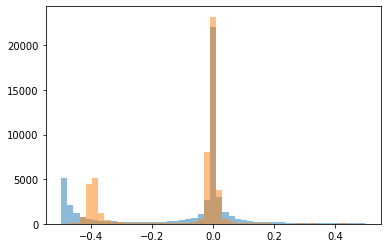

In [51]:
bins = np.linspace(-0.5, 0.5, 50)
plt.hist(all_test, bins=bins,alpha=0.5)
plt.hist(all_pred, bins=bins,alpha=0.5)

## Stacking output (orange) over input (blue) for pT, eta, phi, m

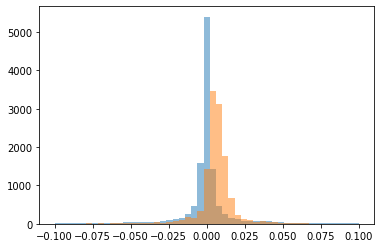

In [48]:
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

(array([5.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 8.000e+00, 4.000e+00,
        9.000e+00, 6.000e+00, 3.000e+00, 7.000e+00, 1.100e+01, 1.400e+01,
        9.000e+00, 1.200e+01, 2.400e+01, 3.000e+01, 3.600e+01, 5.300e+01,
        9.900e+01, 1.430e+02, 5.700e+02, 3.483e+03, 4.070e+03, 1.506e+03,
        6.160e+02, 3.540e+02, 2.740e+02, 2.380e+02, 1.920e+02, 1.380e+02,
        9.400e+01, 4.800e+01, 4.700e+01, 5.000e+01, 3.100e+01, 2.600e+01,
        2.300e+01, 1.600e+01, 6.000e+00, 1.200e+01, 1.300e+01, 4.000e+00,
        5.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 1.000e+00, 5.000e+00,
        5.000e+00]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  

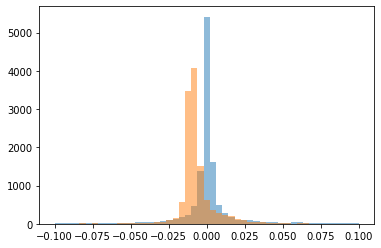

In [47]:
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

(array([3.000e+00, 1.200e+01, 1.700e+01, 6.000e+00, 1.200e+01, 9.000e+00,
        5.000e+00, 1.100e+01, 1.500e+01, 1.200e+01, 2.400e+01, 8.000e+00,
        1.900e+01, 3.600e+01, 3.600e+01, 2.200e+01, 4.500e+01, 5.400e+01,
        9.100e+01, 1.270e+02, 2.300e+02, 4.270e+02, 1.587e+03, 6.942e+03,
        2.003e+03, 1.720e+02, 9.600e+01, 7.100e+01, 5.000e+01, 5.600e+01,
        4.200e+01, 4.500e+01, 2.800e+01, 2.300e+01, 2.400e+01, 1.800e+01,
        1.600e+01, 1.200e+01, 7.000e+00, 2.000e+01, 1.300e+01, 6.000e+00,
        1.000e+01, 2.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 6.000e+00,
        5.000e+00]),
 array([-0.2       , -0.19183673, -0.18367347, -0.1755102 , -0.16734694,
        -0.15918367, -0.15102041, -0.14285714, -0.13469388, -0.12653061,
        -0.11836735, -0.11020408, -0.10204082, -0.09387755, -0.08571429,
        -0.07755102, -0.06938776, -0.06122449, -0.05306122, -0.04489796,
        -0.03673469, -0.02857143, -0.02040816, -0.0122449 , -0.00408163,
         0.00408163,  

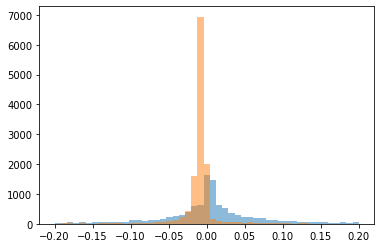

In [46]:
bins = np.linspace(-0.2, 0.2, 50)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

(array([0.000e+00, 0.000e+00, 1.100e+01, 8.005e+03, 3.803e+03, 3.190e+02,
        9.900e+01, 3.600e+01, 3.000e+01, 2.200e+01, 1.700e+01, 8.000e+00,
        9.000e+00, 8.000e+00, 1.300e+01, 5.000e+00, 8.000e+00, 9.000e+00,
        9.000e+00, 1.100e+01, 1.000e+01, 6.000e+00, 1.300e+01, 1.500e+01,
        1.200e+01, 1.600e+01, 1.300e+01, 1.600e+01, 1.300e+01, 1.700e+01,
        2.100e+01, 2.500e+01, 2.500e+01, 3.700e+01, 4.900e+01, 3.300e+01,
        5.600e+01, 6.500e+01, 6.500e+01, 6.300e+01, 6.300e+01, 6.100e+01,
        7.600e+01, 9.300e+01, 9.700e+01, 8.700e+01, 7.400e+01, 8.300e+01,
        6.000e+01]),
 array([-0.6       , -0.54693878, -0.49387755, -0.44081633, -0.3877551 ,
        -0.33469388, -0.28163265, -0.22857143, -0.1755102 , -0.12244898,
        -0.06938776, -0.01632653,  0.03673469,  0.08979592,  0.14285714,
         0.19591837,  0.24897959,  0.30204082,  0.35510204,  0.40816327,
         0.46122449,  0.51428571,  0.56734694,  0.62040816,  0.67346939,
         0.72653061,  

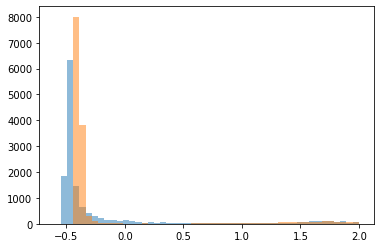

In [45]:
bins = np.linspace(-0.6,2, 50)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [40]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [41]:
bins = np.linspace(-2, 2, 30)

(array([  61.,   69.,   67.,   75.,   86.,   90.,   96.,   90.,   84.,
         104.,  131.,  177.,  183.,  320.,  465.,  517.,  440.,  354.,
         326.,  352.,  504., 1055.,  624.,  362.,  250.,  226.,  179.,
         155.,  154.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

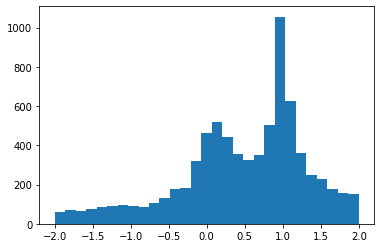

In [42]:
plt.hist(d_px, bins=bins)

(array([ 61.,  62.,  67.,  73.,  75.,  74.,  69.,  85., 103.,  91., 133.,
        153., 224., 324., 476., 551., 399., 325., 280., 294., 386., 761.,
        490., 326., 232., 187., 174., 162., 121.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

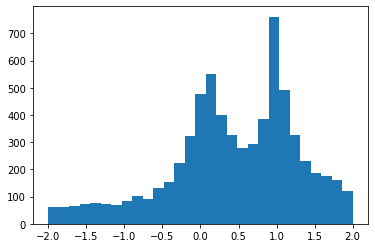

In [43]:
plt.hist(d_py, bins=bins)

(array([  28.,   30.,   40.,   38.,   44.,   29.,   69.,   59.,   61.,
          69.,   96.,  121.,  181.,  271.,  440.,  515.,  419.,  368.,
         440.,  569.,  998., 3049., 1695.,  797.,  502.,  334.,  281.,
         237.,  183.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

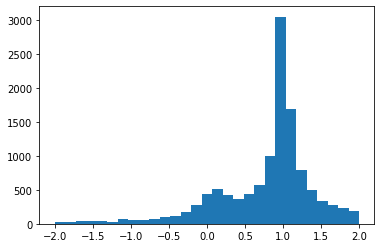

In [44]:
plt.hist(d_pz, bins=bins)